In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

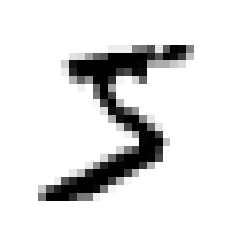

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
import numpy as np

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
y_train_5 = (y_train == 5)

In [13]:
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)

In [16]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
from sklearn.model_selection import StratifiedKFold

In [19]:
from sklearn.base import clone

In [20]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [21]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [24]:
from sklearn.base import BaseEstimator

In [25]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
never_5_clf = Never5Classifier()

In [27]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [28]:
from sklearn.model_selection import cross_val_predict

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [32]:
y_train_perfect_predictions = y_train_5

In [33]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [34]:
from sklearn.metrics import precision_score, recall_score

In [35]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [36]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [37]:
from sklearn.metrics import f1_score

In [38]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [39]:
y_scores = sgd_clf.decision_function([some_digit])

In [40]:
y_scores

array([2164.22030239])

In [41]:
threshold = 0

In [42]:
y_some_digit_pred = (y_scores > threshold)

In [43]:
y_some_digit_pred

array([ True])

In [44]:
threshold = 8000

In [45]:
y_some_digit_pred = (y_scores > threshold)

In [46]:
y_some_digit_pred

array([False])

In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [48]:
from sklearn.metrics import precision_recall_curve

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

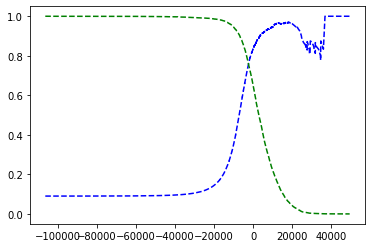

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

In [53]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [54]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [55]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [56]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [57]:
from sklearn.metrics import roc_curve

In [58]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

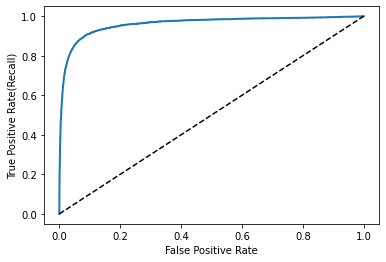

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate(Recall)')

plot_roc_curve(fpr, tpr)

plt.show()

In [60]:
from sklearn.metrics import roc_auc_score

In [61]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
forest_clf = RandomForestClassifier(random_state=42)

In [64]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [65]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

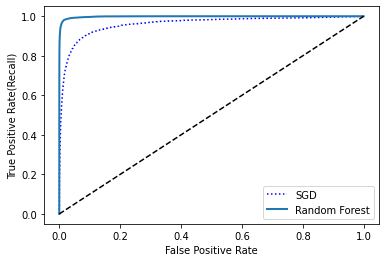

In [66]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [67]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [68]:
from sklearn.svm import SVC

In [69]:
svm_clf = SVC()

In [70]:
svm_clf.fit(X_train, y_train)

SVC()

In [71]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [72]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [73]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [74]:
np.argmax(some_digit_scores)

5

In [75]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [76]:
svm_clf.classes_[5]

5

In [77]:
from sklearn.multiclass import OneVsRestClassifier

In [78]:
ovr_clf = OneVsRestClassifier(SVC())

In [79]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [80]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [81]:
len(ovr_clf.estimators_)

10

In [82]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [86]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [87]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [88]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()

In [91]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [92]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [93]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [94]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [95]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

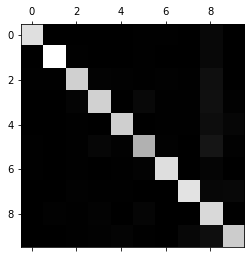

In [96]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [97]:
plt.show()

In [98]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

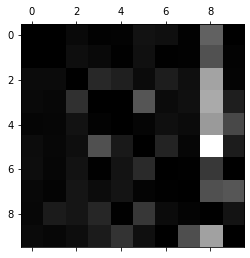

In [99]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [113]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

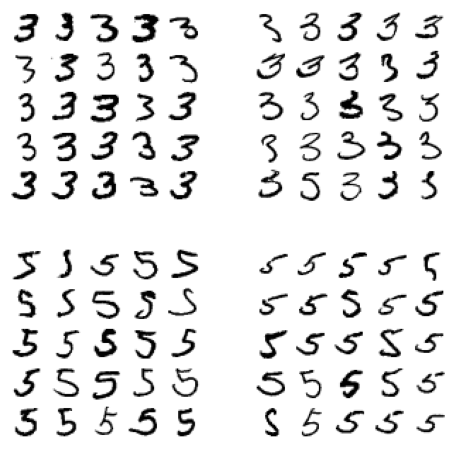

In [116]:
import matplotlib
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [104]:
from sklearn.neighbors import KNeighborsClassifier

In [105]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()

In [106]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [107]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [108]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [109]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [120]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [111]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

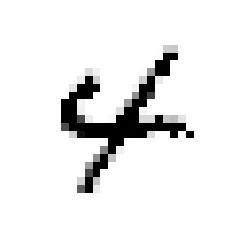

In [123]:
some_index = 5500
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)